<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/WESAD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Exploratory data analysis of dataset

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle
#from pyEDA.main import *
! pip install neurokit2
import neurokit2 as nk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
! ls /content/drive/MyDrive/stress-prediction

cvxEDA.py  data  data_wrangling.py  files  logs  models  __pycache__  WESAD


In [4]:
#! cd /content/drive/MyDrive/stress-prediction/ # Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

## Open and clean up raw data
The data for swell and wsead is stored in seperate folders. Within each of these is a subfolder holding the eda, rri, and Labels folders

In [5]:
original_dir = os.path.join(PATH, 'original')
org_WESAD_dir = os.path.join(original_dir, 'WESAD')
#process_eda_swell_files = glob.glob(os.path.join(org_WESAD_dir, "*.pkl"))
print(org_WESAD_dir)

/content/drive/MyDrive/stress-prediction/data/original/WESAD


In [6]:
class SubjectData:
    # https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
    '''
    Object stores the raw WESAD data and has helper functions to extract
    wrist or chest data.
    '''
    def __init__(self, main_path, subject_number):
        #print(main_path)
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        # set the labels, 2 = stress (reset to 1), all others set to 0
        self.labels = self.data['label']
        self.labels[self.labels > 2] = 0
        self.labels[self.labels < 2] = 0
        self.labels[self.labels == 2] = 1
        #self.labels[self.labels == 1 |self.labels == 3 | self.labels == 3] = 0
        #self.labels[self.labels == 2] = 1

    def get_wrist_data(self):
        data = self.data['signal']['chest']
        data.update({'RSP': self.data['signal']['chest']['Resp']})
        data.update({'ECG' : self.data['signal']['chest']['ECG']})
        data.update({'EMG' : self.data['signal']['chest']['EMG']})
        data.update({'HRV' : self.data['signal']['wrist']['BVP']})
        data['labels'] = self.labels
               
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

        return results


In [7]:
def subject_data_import(directory):
  '''
  WESAD raw data is stored in a pkl file of each specific subject.
  This function scans through the directories and imports the pkl files.
  It then calls the SubjectData object and stores the subject dictionaries.
  '''
  import regex as re

  regex = re.compile(r'\d+')
  subject_li = []
  ext = '.pkl' # pickle extension
  # Walk through data directory and only return with specific extension
  for path, dirc, files in os.walk(directory):
    for name in files:
      if name.endswith(ext):
        subject_number = regex.findall(name) # Extract the subject number
        subject_li.append(SubjectData(directory, int(subject_number[0]))) # Create SubjectData object

  return subject_li

In [8]:
# Store all subject data into a list of SubjectData objects for easier use
wesad_sd_li = subject_data_import(org_WESAD_dir)

## Dictionary analysis


In [9]:
# Extract wrist data and store in a list
# Will create a list of dictionaries for each subject
wesad_data_li = [ f.get_wrist_data() for f in wesad_sd_li ]

In [10]:
wesad_data_li[0].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'RSP', 'HRV', 'labels'])

In [11]:
wesad_data_li[0]['EDA'].reshape(-1)

array([0.71601868, 0.7144928 , 0.71563721, ..., 1.70440674, 1.74827576,
       1.72462463])

In [12]:
sum(wesad_data_li[0]['EDA'].reshape(-1))

4931256.0916900635

In [15]:
#from sklearn.preprocessing import normalize
#print(wesad_data_li[0]['EDA'].reshape(-1)[0:10])
#norm_EDA = normalize(wesad_data_li[0]['EDA'].reshape(1, -1))[0:10]

[0.71601868 0.7144928  0.71563721 0.71487427 0.71525574 0.71372986
 0.71296692 0.71372986 0.71144104 0.71258545]


In [17]:
# Clean and process raw data using Neurokit2

# process the data (filter, find peaks, ect.)
# Only on one subject index=0
processed_data, info = nk.bio_process(eda=wesad_data_li[0]['EDA'].reshape(-1),
                                      #ecg=wesad_data_li[0]['ECG'].reshape(-1),
                                      #hrv=wesad_data_li[0]['HRV'].reshape(-1),
                                      #emg=wesad_data_li[0]['EMG'].reshape(-1),
                                      sampling_rate=700)

In [18]:
# Data size
print(len(wesad_data_li[0]['EDA']))
# Drop rows that all data is Nan
processed_data.dropna(how='all', inplace=True)
len(processed_data)

3847200


3847200

In [19]:
# Inspect processed data dataframe
processed_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   EDA_Raw           3847200 non-null  float64
 1   EDA_Clean         3847200 non-null  float64
 2   EDA_Tonic         3847200 non-null  float64
 3   EDA_Phasic        3847200 non-null  float64
 4   SCR_Onsets        3847200 non-null  int64  
 5   SCR_Peaks         3847200 non-null  int64  
 6   SCR_Height        3847200 non-null  float64
 7   SCR_Amplitude     3847200 non-null  float64
 8   SCR_RiseTime      3847200 non-null  float64
 9   SCR_Recovery      3847200 non-null  int64  
 10  SCR_RecoveryTime  3847200 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 322.9 MB


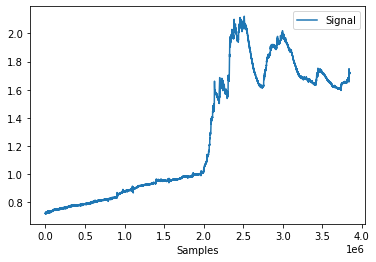

In [20]:
# inspect the cleaned EDA signal
nk.signal_plot(processed_data['EDA_Clean'])

In [21]:
# What are the unique label IDs?
np.unique(wesad_data_li[0]['labels'])

array([0, 1], dtype=int32)

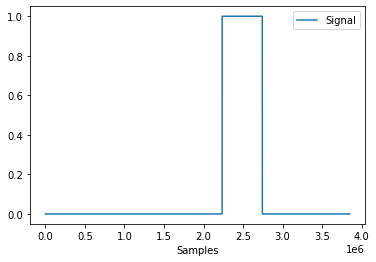

In [22]:
# Plot the signal
nk.signal_plot(wesad_data_li[0]['labels'])

In [23]:
len(wesad_data_li[0]['labels'])

3847200

array([[<Axes: title={'center': '0'}>]], dtype=object)

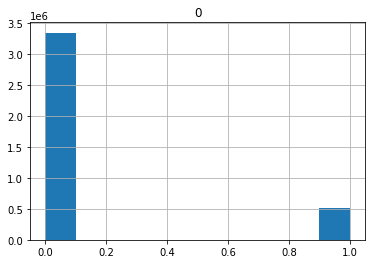

In [24]:
pd.DataFrame(wesad_data_li[0]['labels']).hist()

In [25]:
#condition_list = ['normal', 'stress', 'normal']
events = nk.events_find(event_channel=wesad_data_li[0]['labels'])#,
                        #threshold=0,
                        #threshold_keep="above",
                        #event_conditions=condition_list)
events

{'onset': array([2234999]),
 'duration': array([507500]),
 'label': array(['1'], dtype='<U21')}

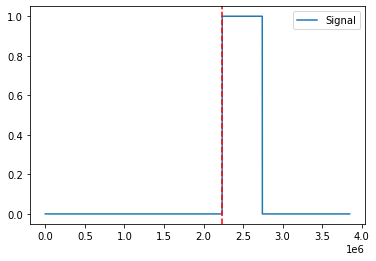

In [26]:
plot = nk.events_plot(events, wesad_data_li[0]['labels'])

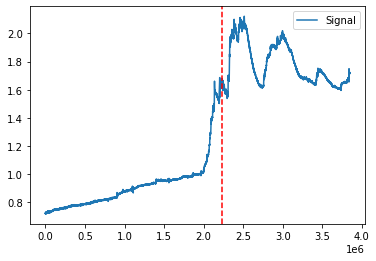

In [27]:
plot = nk.events_plot(events, processed_data['EDA_Clean'])

In [28]:
processed_data.keys()

Index(['EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')

EDA_Raw
EDA_Clean
EDA_Tonic
EDA_Phasic
SCR_Onsets
SCR_Peaks
SCR_Height
SCR_Amplitude
SCR_RiseTime
SCR_Recovery
SCR_RecoveryTime


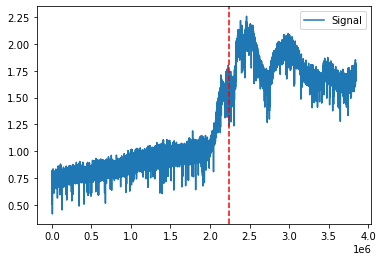

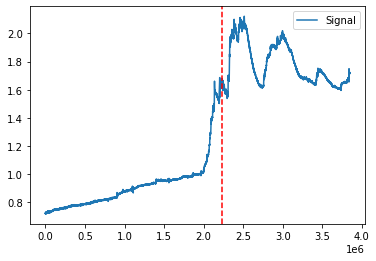

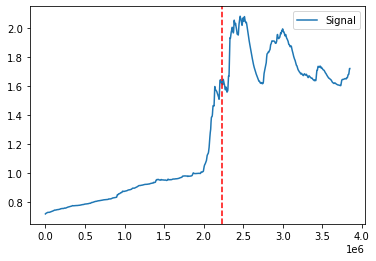

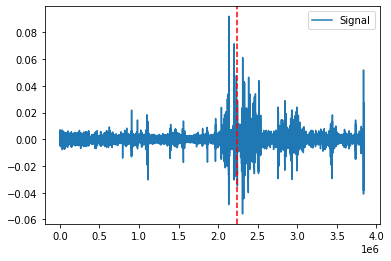

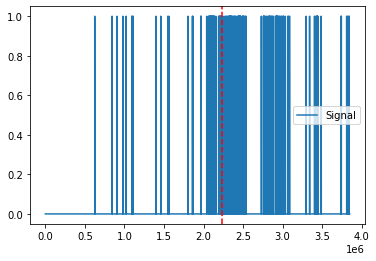

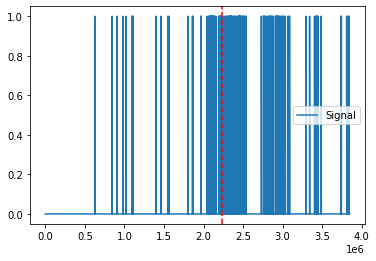

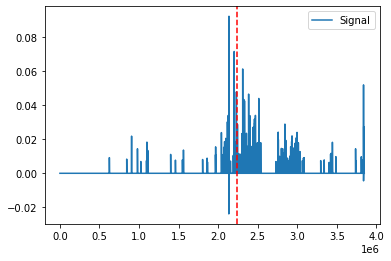

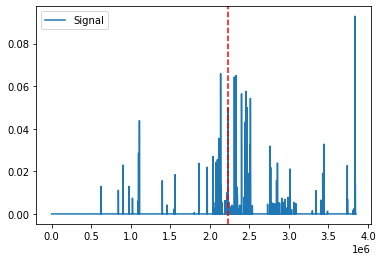

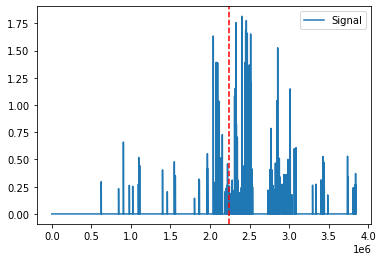

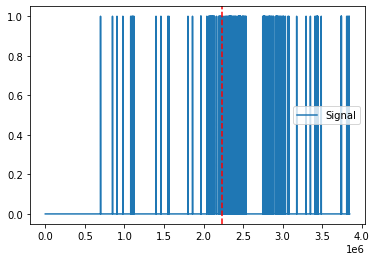

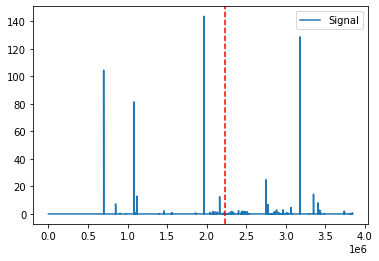

In [29]:
for key in processed_data.keys():
  print(key)
  nk.events_plot(events, processed_data[key])

In [30]:
'''
From the graphs the following features look differentiable
'EDA_Tonic', 
'EDA_Phasic', 
'SCR_Height'
'''
processed_data_subset = processed_data[['EDA_Tonic', 'EDA_Phasic', 'SCR_Height']]
processed_data_subset


,EDA_Tonic,EDA_Phasic,SCR_Height
0,0.720871,-0.002589,0.0
1,0.720872,-0.002616,0.0
2,0.720873,-0.002641,0.0
3,0.720874,-0.002665,0.0
4,0.720875,-0.002688,0.0
...,...,...,...
3847195,1.723146,-0.000035,0.0
3847196,1.723146,-0.000032,0.0
3847197,1.723146,-0.000029,0.0
3847198,1.723146,-0.000027,0.0


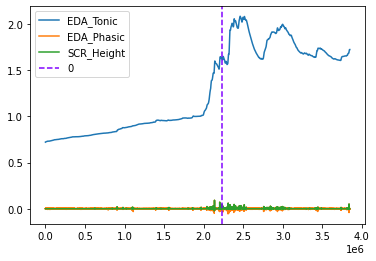

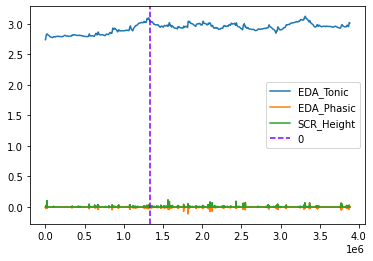

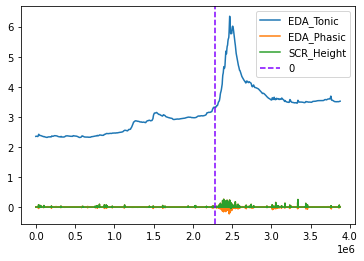

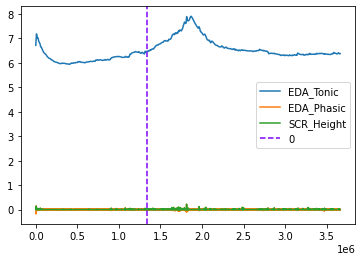

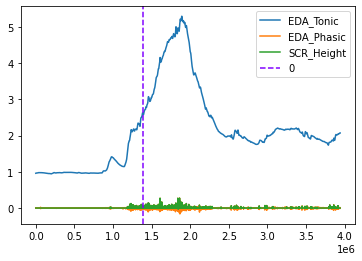

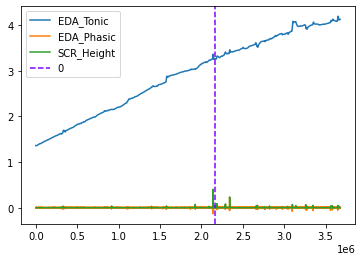

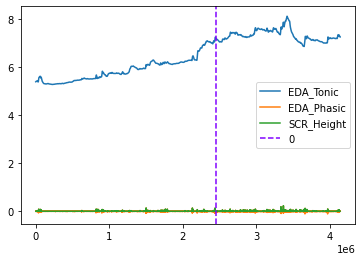

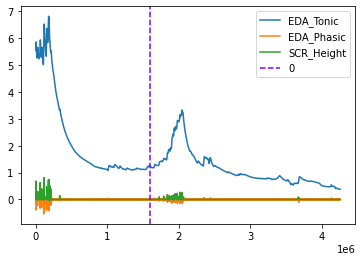

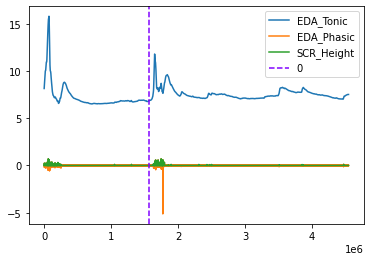

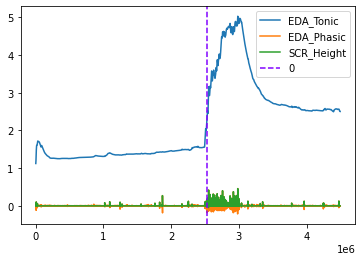

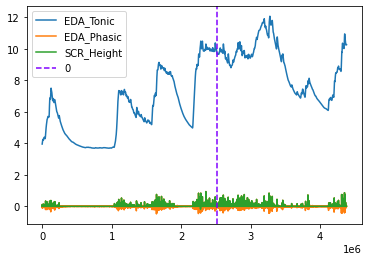

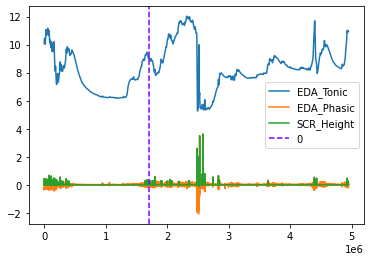

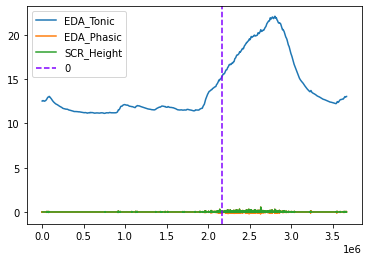

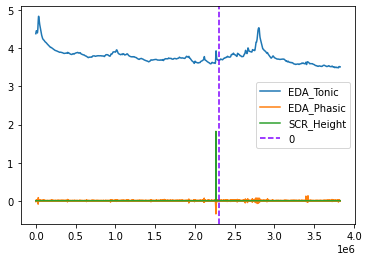

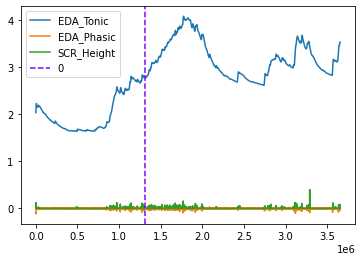

In [31]:
def plot_events(data, condition_list):
  #numplots = round(len(wesad_data_li) / 4)
  #fig, axes = plt.subplots(4, numplots, figsize=(10,10), sharex=True, sharey=True)

  # iterate over the SubjectData objects stored in wesad_data_li
  for idx, subject in enumerate(data):

    #batch_no = len(data[idx]['labels'])//len(data[idx]['EDA'])
    #print(batch_no)
    labels = data[idx]['labels']
    processed_data, info = nk.bio_process(eda=subject['EDA'], sampling_rate=700)
    processed_data_subset = processed_data[['EDA_Tonic', 'EDA_Phasic', 'SCR_Height']]

    events = nk.events_find(event_channel=wesad_data_li[idx]['labels'],
                            threshold_keep='above',
                            event_conditions=condition_list)
    
    plot = nk.events_plot(events, processed_data_subset)

condition_list = ['stress']
plot_events(wesad_data_li, condition_list)

In [93]:
def modeling_data_process(subject_data_list):

  processed_data, info = nk.bio_process(eda=subject['EDA'], sampling_rate=700)
  processed_data_subset = processed_data[['EDA_Tonic', 'EDA_Phasic', 'SCR_Height']]
  processed_data_subset['labels'] = pd.DataFrame.from_dict(subject['labels'])

  return processed_data_subset

model_data = [ modeling_data_process(subject) for subject in wesad_data_li]

<ipython-input-93-f2b04c6aad9a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data_subset['labels'] = pd.DataFrame.from_dict(subject['labels'])
<ipython-input-93-f2b04c6aad9a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data_subset['labels'] = pd.DataFrame.from_dict(subject['labels'])
<ipython-input-93-f2b04c6aad9a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [95]:
# Create the datasets using `timeseries_dataset_from_array`


# Pickle and save
import joblib
joblib.dump(model_data, "data/pickle/WESAD_model_data.pickle") # write pickle file
#joblib.dump(labels, "data/pickle/WESAD_labels_model.pickle") # write pickle file

['data/pickle/WESAD_model_data.pickle']